In [1]:
import pandas as pd
import numpy as np
import pickle
import glob

In [2]:
journey_cols = [
    'timestamp', 
    'event', 
    'vehicle_id', 
    'line', 
    'longitude', 
    'latitude', 
    'direction', 
    'speed', 
    'station',
    'journey_number',
    'segment_number'
]

df = pd.DataFrame(columns=journey_cols).astype(dtype={
    'timestamp': 'object', 
    'event': 'object',
    'vehicle_id': 'int64',
    'line': 'int64',
    'longitude': 'float64', 
    'latitude': 'float64',
    'direction': 'float64',
    'speed': 'float64',
    'station': 'object',
    'journey_number': 'int64',
    'segment_number': 'int64'
})

In [7]:
for f in sorted(glob.glob('/home/max/det-ar-lugnt/buslines/*')):
    df = df.append(pickle.load(open(f, 'rb'))).astype(dtype={
        'timestamp': 'object', 
        'event': 'object',
        'vehicle_id': 'int64',
        'line': 'int64',
        'longitude': 'float64', 
        'latitude': 'float64',
        'direction': 'float64',
        'speed': 'float64',
        'station': 'object',
        'journey_number': 'int64',
        'segment_number': 'int64'
    })

No journey has more than 11 segments, which is good 

In [36]:
df['segment_number'].max()

11

Does some journeys have a fewer than 11 segments?

In [41]:
grouped = df.groupby('journey_number').max().reset_index()

In [45]:
len(grouped[grouped['segment_number'] < 11]['journey_number'])

55

Only 55 journeys, we can drop these..

In [51]:
print('The bad data makes up ~{:.2f}%'.format(100 * 55 / df['journey_number'].nunique()))

The bad data makes up ~1.50%


Lets drop the rows where the journey has a fewer than 11 segments. This should retain around 98.5% of the data.

In [54]:
bad_journeys = grouped[grouped['segment_number'] < 11]['journey_number']

In [61]:
# sanity check
print('The good data that would be kept after dropping make up {:.2f}%'.format(
    100 * len(df[~df['journey_number'].isin(bad_journeys)].index) / len(df.index)))

The good data that would be kept after dropping make up 98.76%


In [63]:
df = df[~df['journey_number'].isin(bad_journeys)]

Which unique stations do we have? 

In [95]:
_ = [print(s) for s in df['station'].unique()]

None
Rydsv\xe4gens \xe4ndh\xe5llpl.
Bj\xf6rnk\xe4rrsskolan
Als\xe4ttersgatan
Rydsv\xe4gen 236
Rydsv\xe4gen 168
M\xe5rdtorpsgatan
Ryd centrum
Ostbrickan
Solhaga
Gamla Link\xf6ping
Vallaplan
Parkgatan Link\xf6ping


In [99]:
print('Number of unique stations: {}'.format(len(df['station'].unique())))

Number of unique stations: 13


The number of unique stations look correct, i.e. we don't have any stations that *shouldn't* be part of the journey. 

Do we have the same number of unique stations for every journey?

Note: we set `dropna=False` to also count the stations marked `None` due to missing station data some events, such as the *ObservedPositionEvent*

In [101]:
grouped = df.groupby('journey_number')['station'].nunique(dropna=False)

In [102]:
grouped.unique()

array([13, 12])

Seems we have some journeys with only 12 unique stations, where it should be 13. Thankfully there are only a few of these journeys:

In [105]:
grouped[grouped.apply(lambda x: x != 13)]

journey_number
848     12
860     12
1051    12
1197    12
1217    12
1957    12
Name: station, dtype: int64

In [111]:
bad_journeys = [x for x in grouped[grouped.apply(lambda x: x != 13)].index]

We can check what happend in these journeys to make them have fewer unique stations..

In [116]:
for journey in bad_journeys:
    print(f'journey: {journey}')
    _= [print(s) for s in df[df['journey_number'] == journey]['station'].unique()]
    print('\n')

journey: 848
None
Bj\xf6rnk\xe4rrsskolan
Als\xe4ttersgatan
Rydsv\xe4gen 236
Rydsv\xe4gen 168
M\xe5rdtorpsgatan
Ryd centrum
Ostbrickan
Solhaga
Gamla Link\xf6ping
Vallaplan
Parkgatan Link\xf6ping


journey: 860
None
Bj\xf6rnk\xe4rrsskolan
Als\xe4ttersgatan
Rydsv\xe4gen 236
Rydsv\xe4gen 168
M\xe5rdtorpsgatan
Ryd centrum
Ostbrickan
Solhaga
Gamla Link\xf6ping
Vallaplan
Parkgatan Link\xf6ping


journey: 1051
None
Bj\xf6rnk\xe4rrsskolan
Als\xe4ttersgatan
Rydsv\xe4gen 236
Rydsv\xe4gen 168
M\xe5rdtorpsgatan
Ryd centrum
Ostbrickan
Solhaga
Gamla Link\xf6ping
Vallaplan
Parkgatan Link\xf6ping


journey: 1197
None
Bj\xf6rnk\xe4rrsskolan
Als\xe4ttersgatan
Rydsv\xe4gen 236
Rydsv\xe4gen 168
M\xe5rdtorpsgatan
Ryd centrum
Ostbrickan
Solhaga
Gamla Link\xf6ping
Vallaplan
Parkgatan Link\xf6ping


journey: 1217
None
Bj\xf6rnk\xe4rrsskolan
Als\xe4ttersgatan
Rydsv\xe4gen 236
Rydsv\xe4gen 168
M\xe5rdtorpsgatan
Ryd centrum
Ostbrickan
Solhaga
Gamla Link\xf6ping
Vallaplan
Parkgatan Link\xf6ping


journey: 1957
Non

Seems they fired their *JourneyStartedEvent* at Björnkärrsskolan, the station after Rydsvägens Ändhållplats.

Lets drop these journeys as well.

In [118]:
df = df[~df['journey_number'].isin(bad_journeys)]

In [121]:
print('We are left with {} journeys, comprising {} rows'.format(len(df['journey_number'].unique()), len(df.index)))

We are left with 3603 journeys, comprising 6935530 rows


I can't think of anything else to check for right now, anyone have some ideas?

In [122]:
df.to_csv('bus203_all.csv')

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

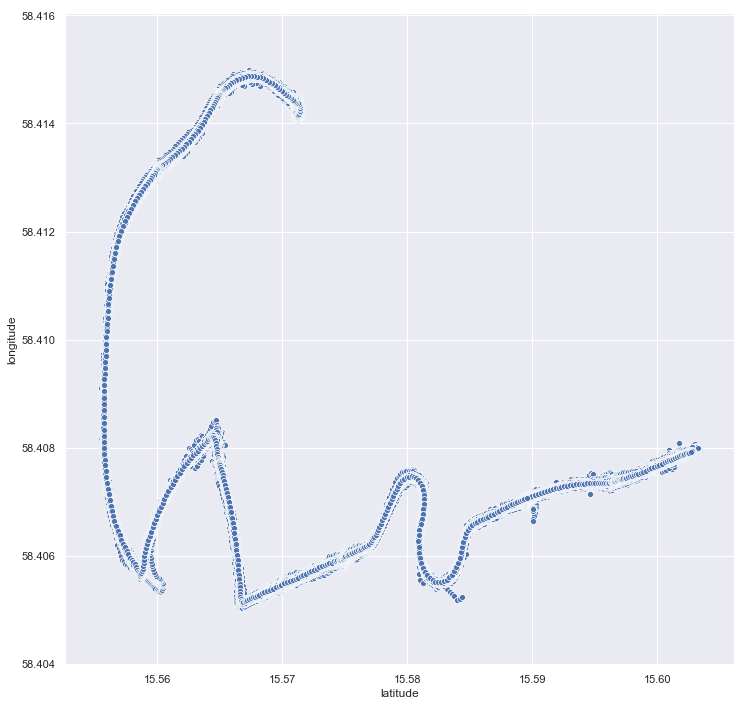

In [131]:
fig, ax = plt.subplots(1, figsize=(12,12))
sns.scatterplot(df['latitude'], df['longitude'], ax=ax)
plt.show()

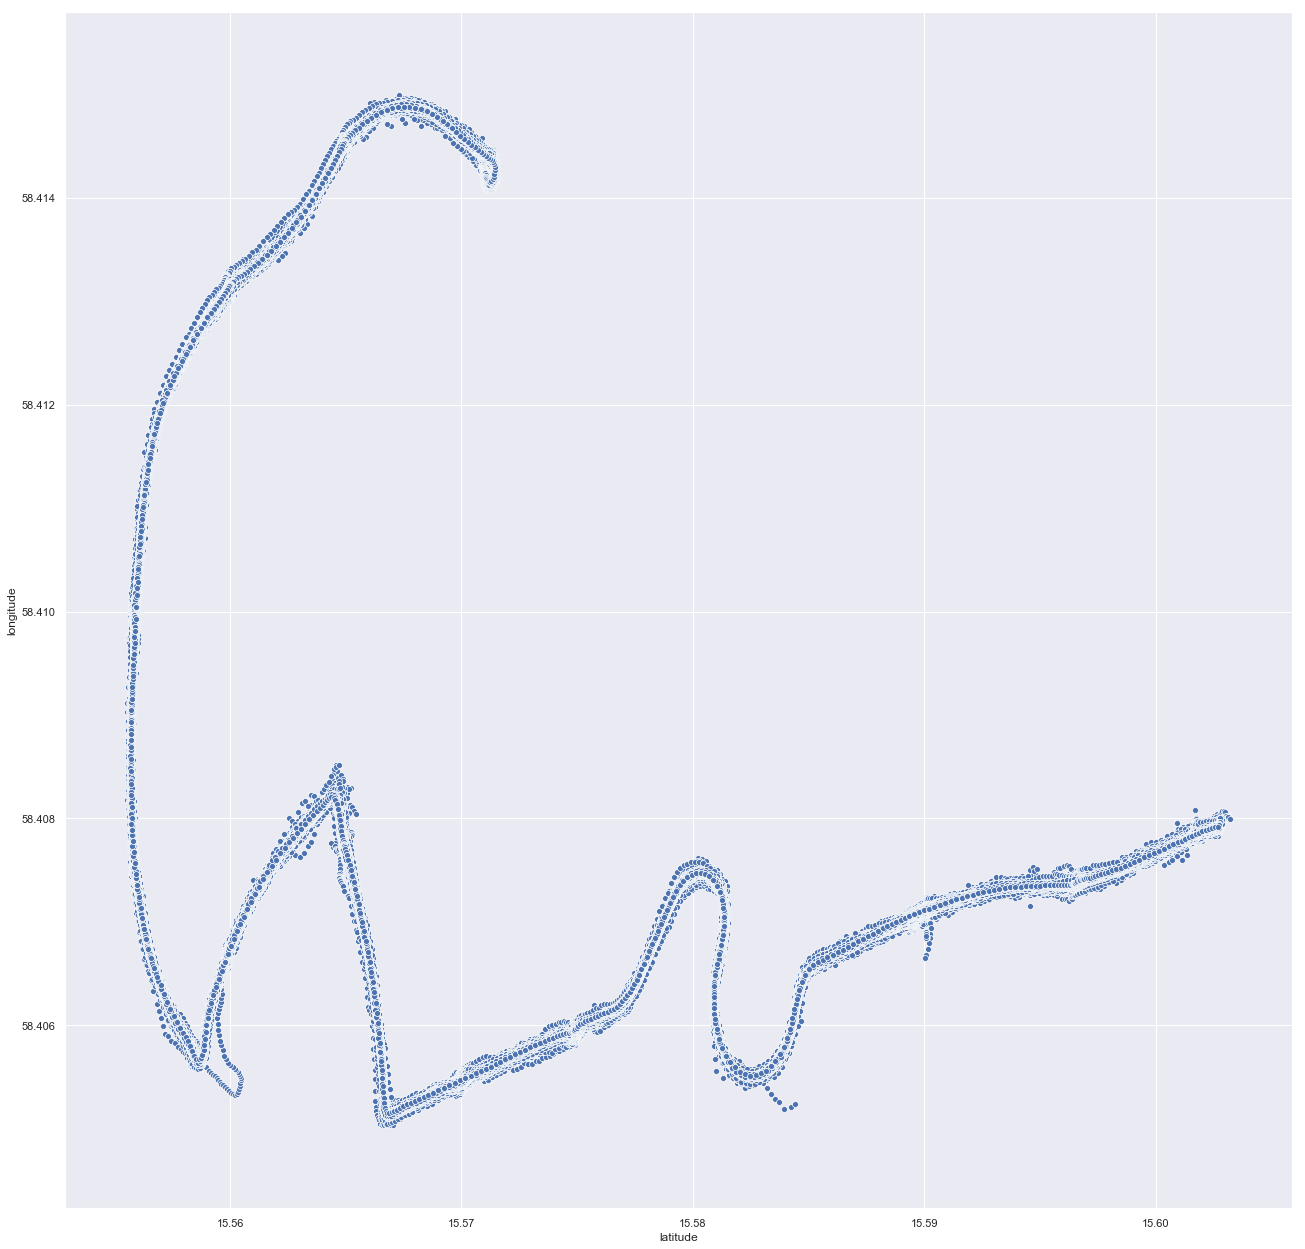

In [133]:
fig, ax = plt.subplots(1, figsize=(22,22))
sns.scatterplot(df['latitude'], df['longitude'], ax=ax)
plt.show()

In [137]:
df[(df['latitude'] > 15.5599) & (df['latitude'] < 15.5601) & (df['longitude'] < 58.406)]['journey_number'].unique()

array([366])

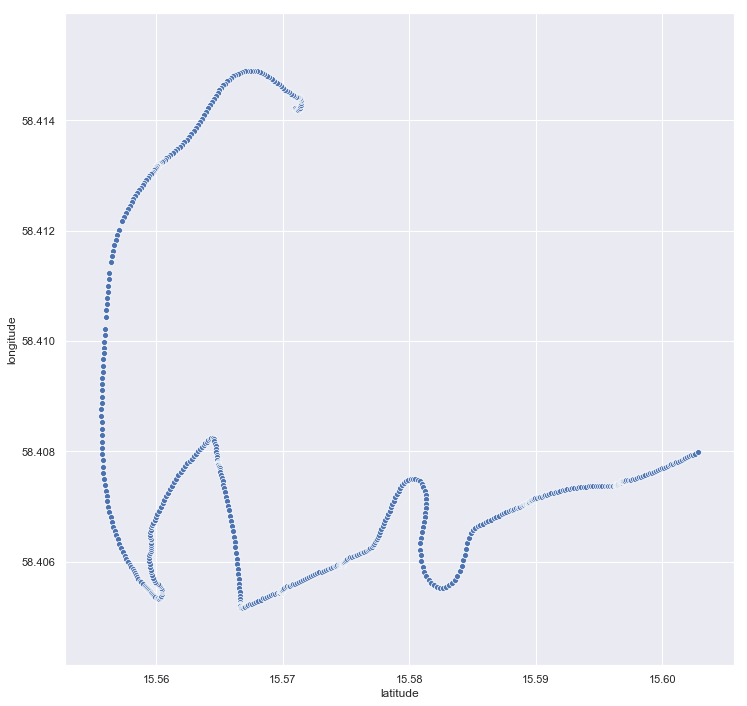

In [138]:
fig, ax = plt.subplots(1, figsize=(12,12))
sns.scatterplot(df[df['journey_number'] == 366]['latitude'], df[df['journey_number'] == 366]['longitude'], ax=ax)
plt.show()

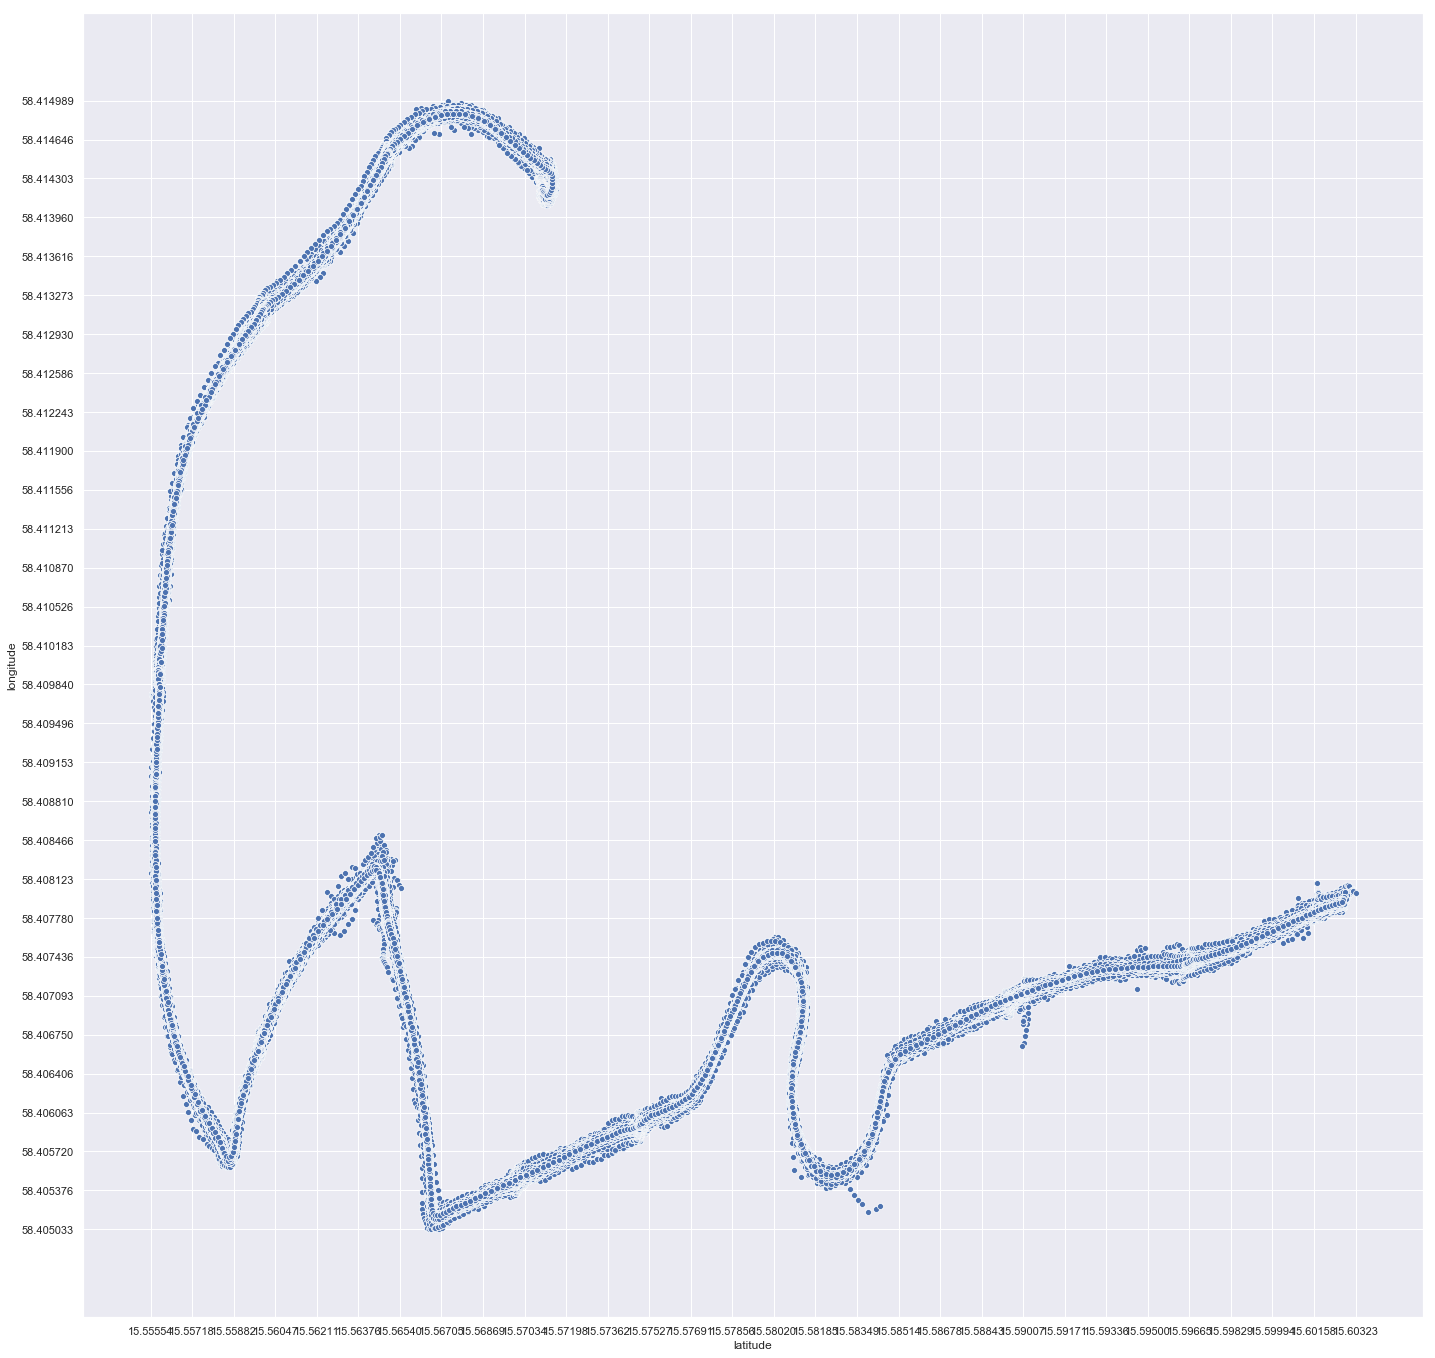

In [143]:
fig, ax = plt.subplots(1, figsize=(24,24))
sns.scatterplot(df[df['journey_number'] != 366]['latitude'], df[df['journey_number'] != 366]['longitude'], ax=ax)
ax.set_xticks(np.linspace(df['latitude'].min(), df['latitude'].max(), 30))
ax.set_yticks(np.linspace(df['longitude'].min(), df['longitude'].max(), 30))
plt.show()

In [144]:
df[(df['latitude'] > 15.5834) & (df['longitude'] < 58.405376)]['journey_number'].unique()

array([2820])

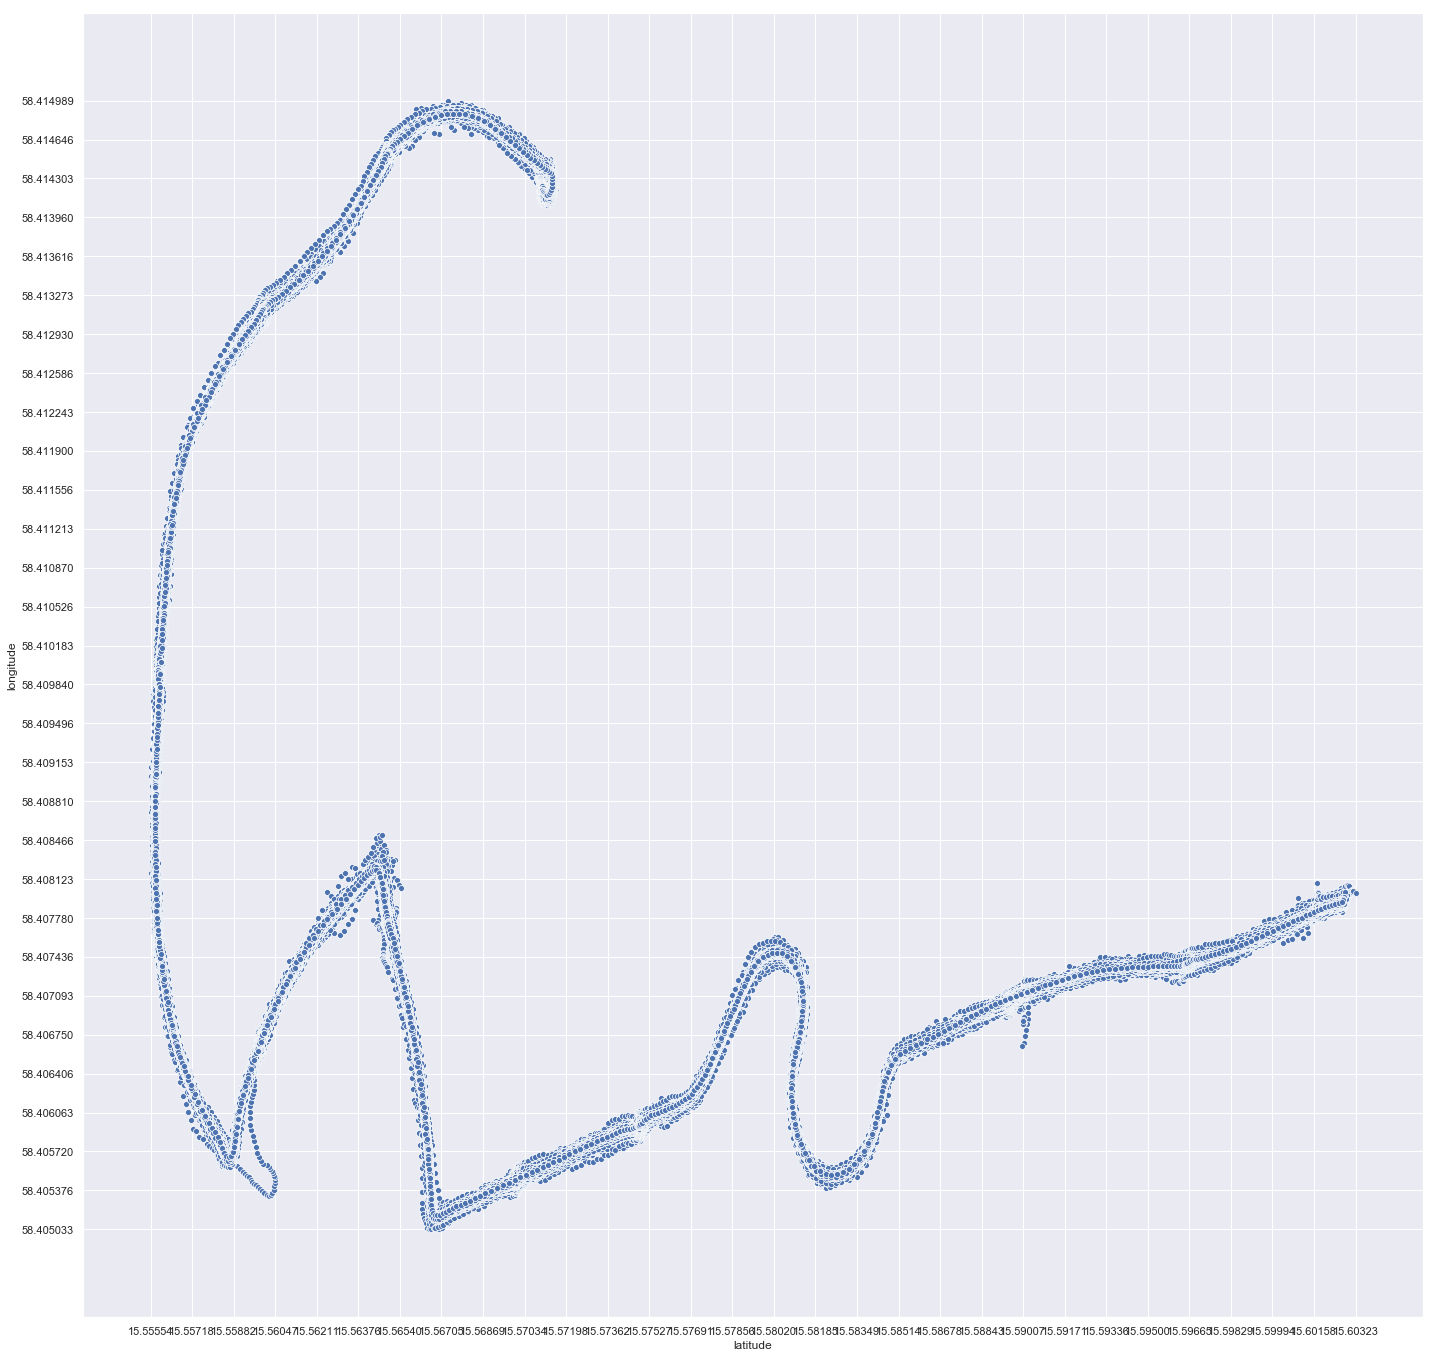

In [145]:
fig, ax = plt.subplots(1, figsize=(24,24))
sns.scatterplot(df[df['journey_number'] != 2820]['latitude'], df[df['journey_number'] != 2820]['longitude'], ax=ax)
ax.set_xticks(np.linspace(df['latitude'].min(), df['latitude'].max(), 30))
ax.set_yticks(np.linspace(df['longitude'].min(), df['longitude'].max(), 30))
plt.show()

In [146]:
df[(df['latitude'] > 15.5900) & (df['longitude'] < 58.406750)]['journey_number'].unique()

array([2404])

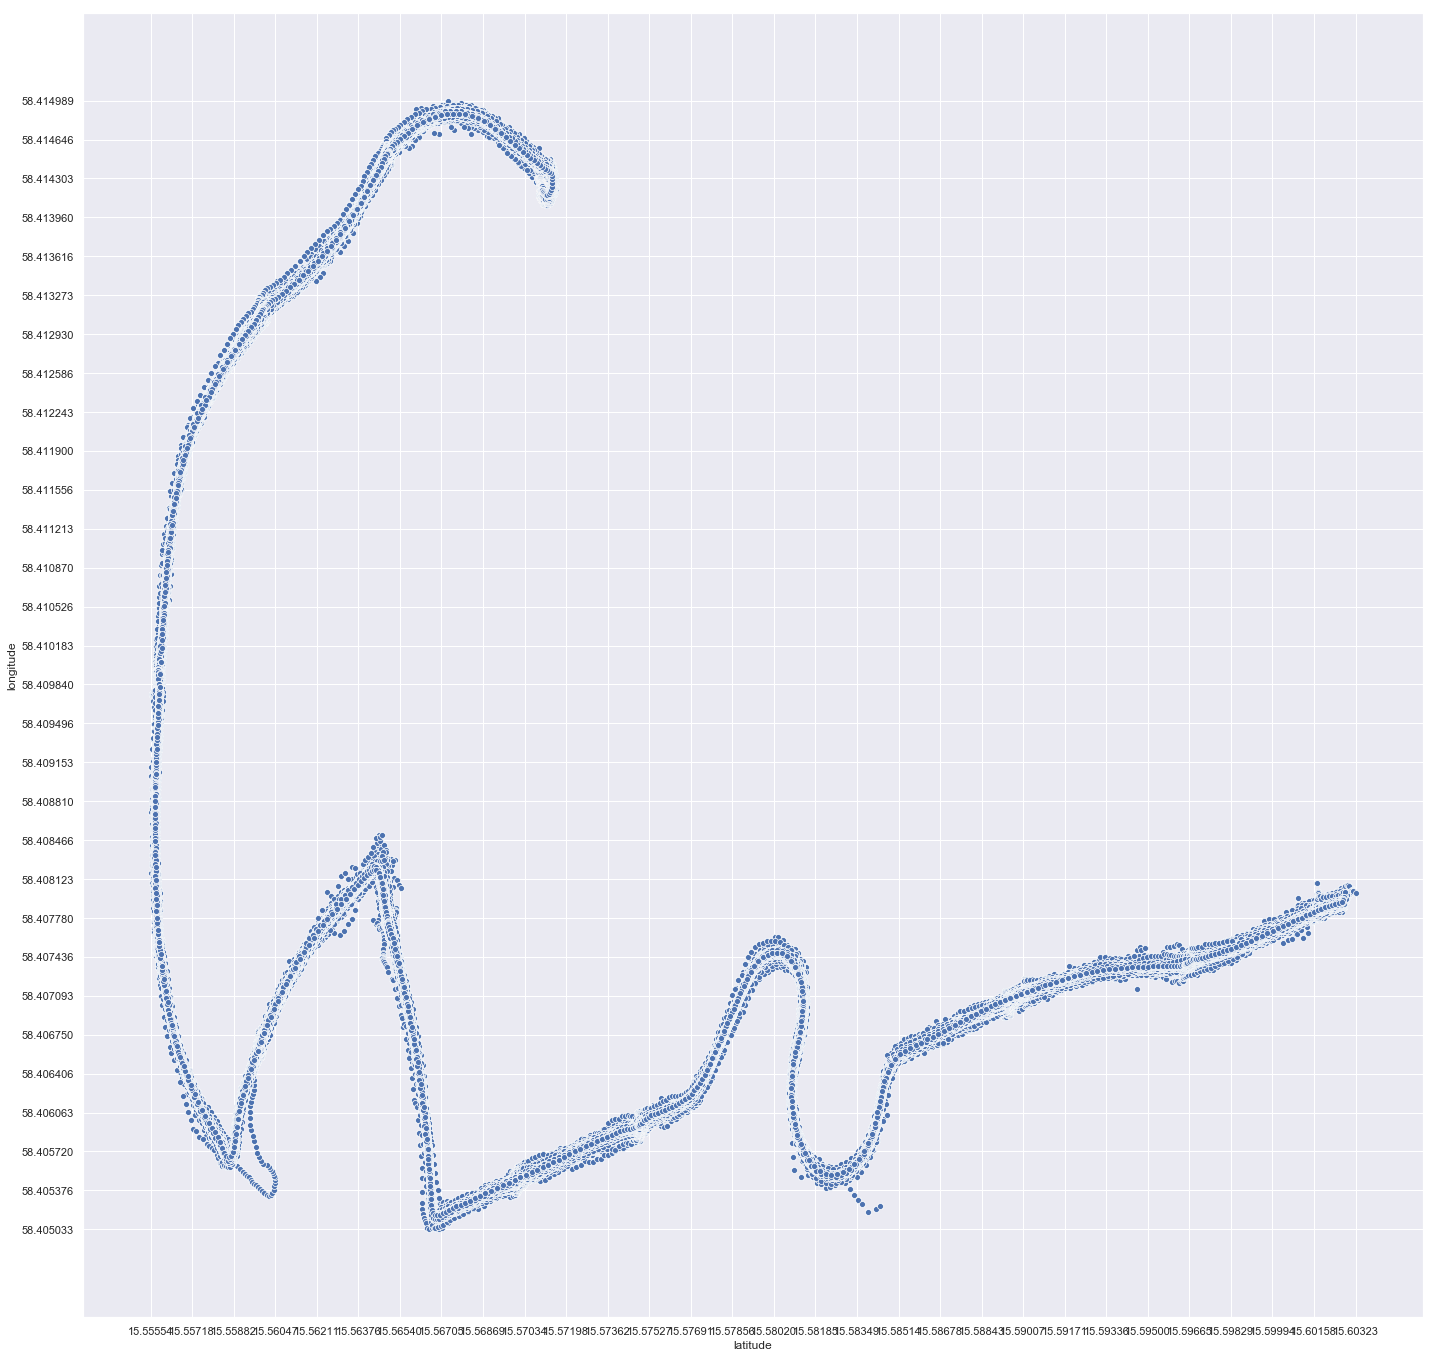

In [147]:
fig, ax = plt.subplots(1, figsize=(24,24))
sns.scatterplot(df[df['journey_number'] != 2404]['latitude'], df[df['journey_number'] != 2404]['longitude'], ax=ax)
ax.set_xticks(np.linspace(df['latitude'].min(), df['latitude'].max(), 30))
ax.set_yticks(np.linspace(df['longitude'].min(), df['longitude'].max(), 30))
plt.show()

The journeys with strange coordinates / incorrect route driven by busdriver are the following:
366, 2820, 2404

In [148]:
bad_drivers = [366, 2820, 2404]

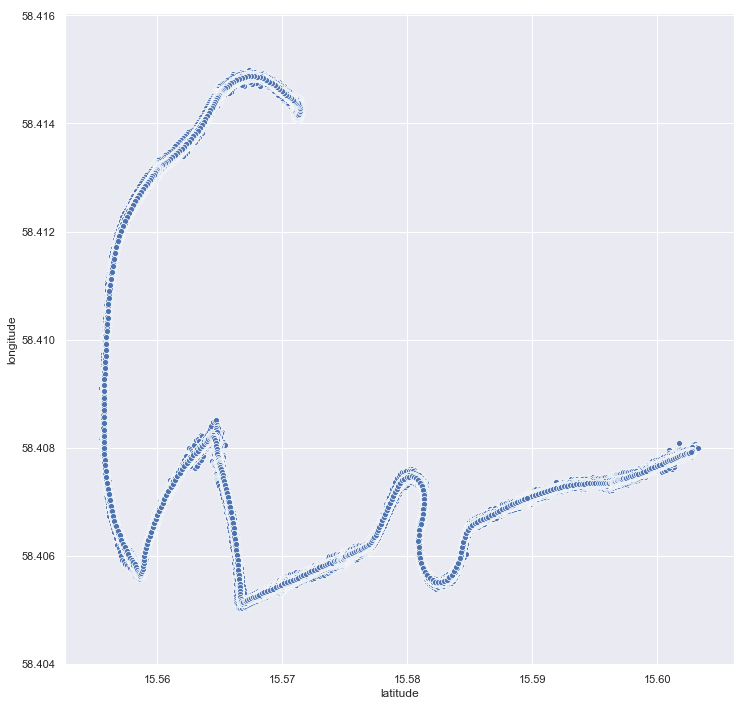

In [149]:
fig, ax = plt.subplots(1, figsize=(12,12))
sns.scatterplot(
    df[~df['journey_number'].isin(bad_drivers)]['latitude'], 
    df[~df['journey_number'].isin(bad_drivers)]['longitude'], 
    ax=ax
)
plt.show()

In [150]:
df = df[~df['journey_number'].isin(bad_drivers)]

In [153]:
df.to_csv('bus203_all.csv')